In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure as fig
import seaborn as sns
import sklearn
from sklearn import model_selection
from sklearn import preprocessing
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

In [41]:
#Data
df = pd.read_csv("correct.csv")
dum = pd.get_dummies(df['city'])
df = pd.concat([dum,df],axis=1)
df = df.drop(columns = ['city'])
df = df.drop(columns = ['week_start_date'])
ef = pd.read_csv("dengue/dengue_labels_train.csv")
ef = ef.drop(columns = ['year','weekofyear','city'])

#Data for inference
ind = pd.read_csv("Dengue/dengue_features_test.csv")
dum = pd.get_dummies(ind['city'])
ind = pd.concat([dum,ind],axis=1)
ind = ind.drop(columns = ['city'])
ind = ind.drop(columns = ['week_start_date'])

In [42]:
print(ind.info())
#print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 24 columns):
iq                                       416 non-null uint8
sj                                       416 non-null uint8
year                                     416 non-null int64
weekofyear                               416 non-null int64
ndvi_ne                                  373 non-null float64
ndvi_nw                                  405 non-null float64
ndvi_se                                  415 non-null float64
ndvi_sw                                  415 non-null float64
precipitation_amt_mm                     414 non-null float64
reanalysis_air_temp_k                    414 non-null float64
reanalysis_avg_temp_k                    414 non-null float64
reanalysis_dew_point_temp_k              414 non-null float64
reanalysis_max_air_temp_k                414 non-null float64
reanalysis_min_air_temp_k                414 non-null float64
reanalysis_precip_amt_kg_per_m2    

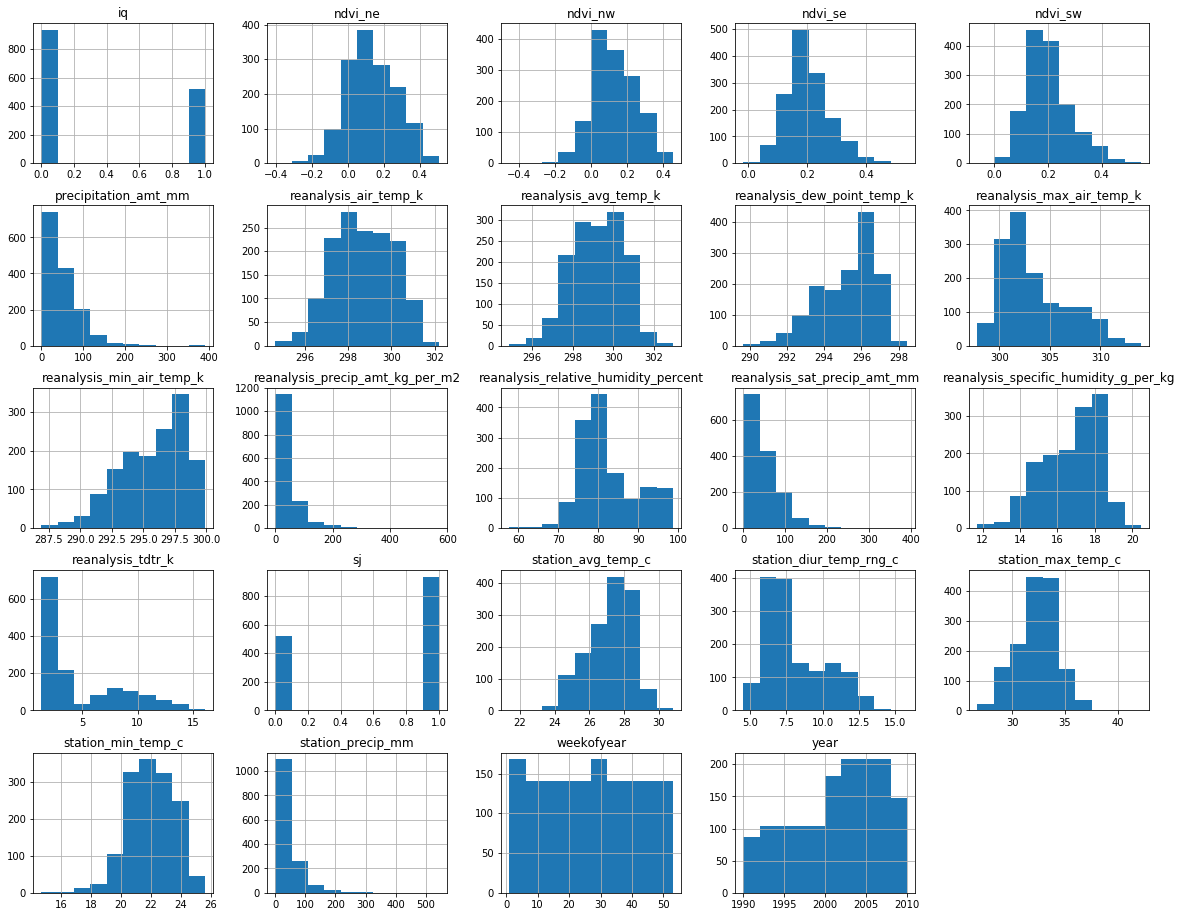

In [43]:
#histogram for all features
df.hist(figsize=(20,16))
plt.show()

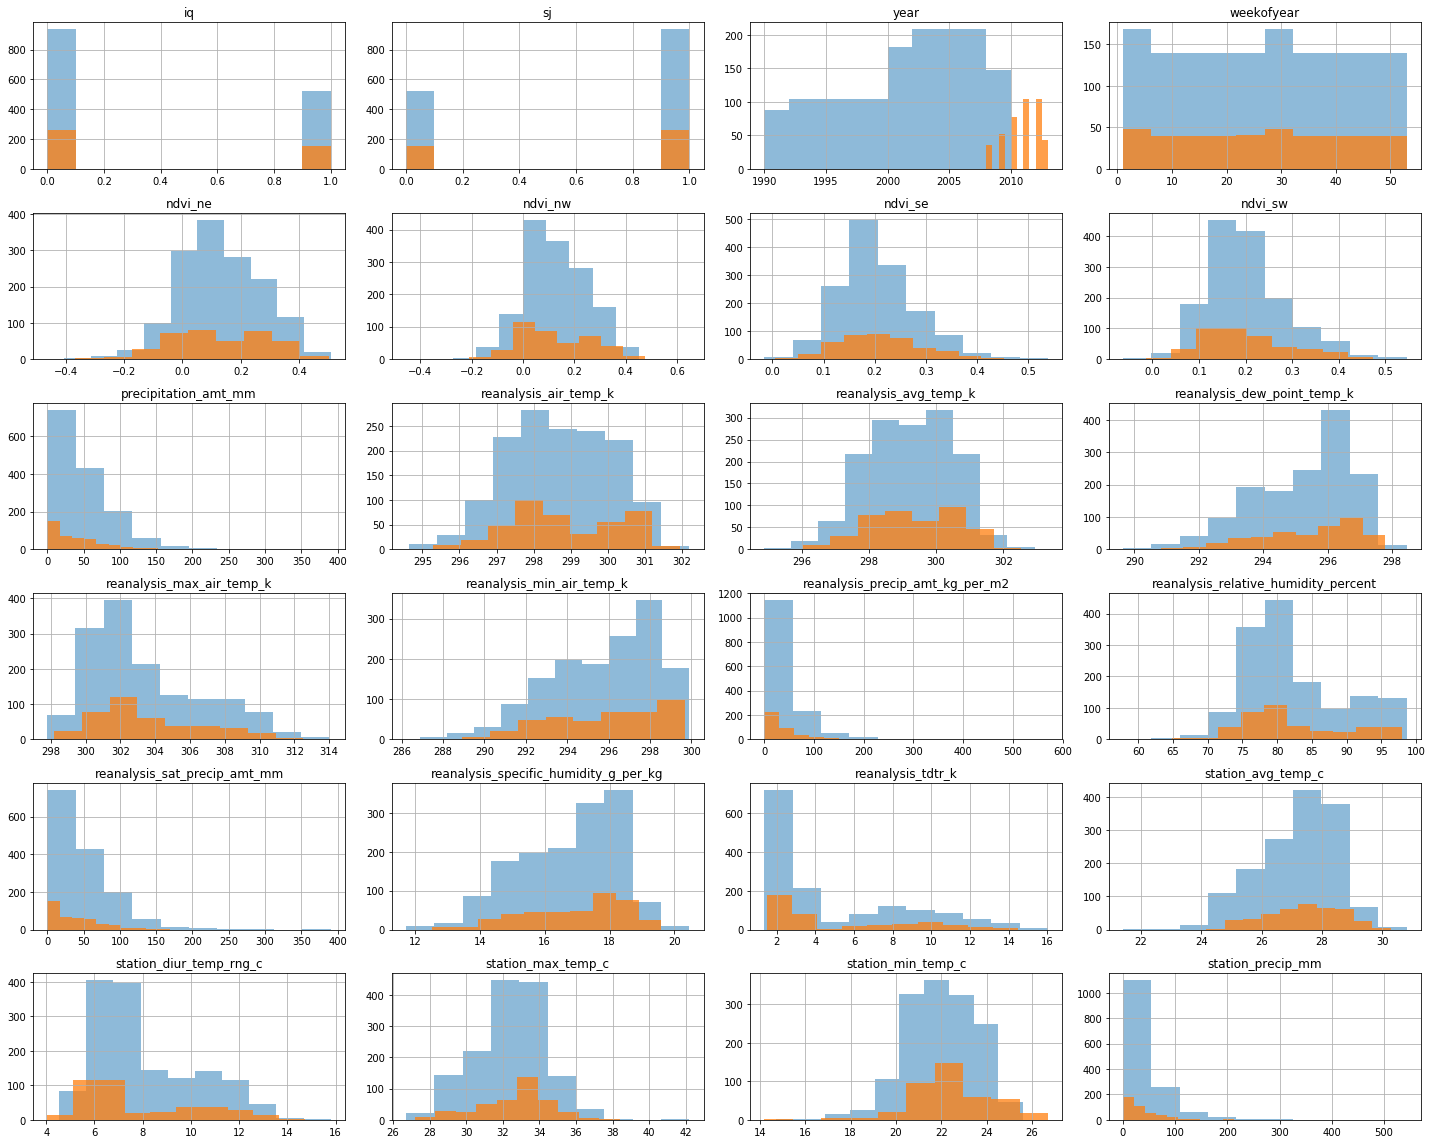

In [44]:

for c1,i in zip(df.columns,range(1,25)):
    plt.tight_layout()
    plt.subplot(6, 4, i) 
    df[c1].hist(figsize=(20,16),alpha=0.5, label=c1)
    ind[c1].hist(figsize=(20,16),alpha=0.75, label=c1)
    plt.title(c1)
    
    

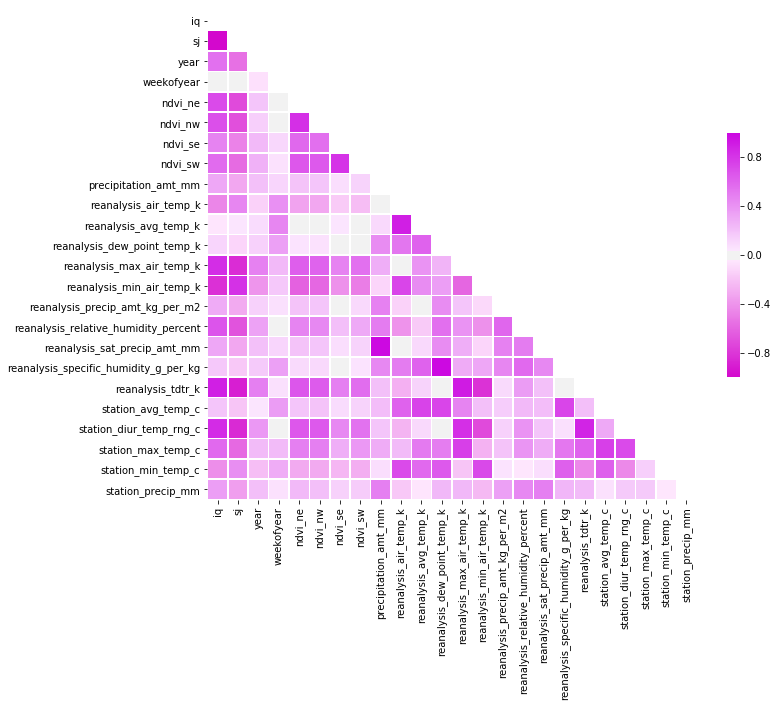

In [45]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(310, 300,s=99, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap,vmax = 1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [46]:
def add_interactions(df):
    # Get feature names
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + [' + '.join(x) for x in combos]
    
    # Find interactions
    poly = PolynomialFeatures(degree = 2,interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    return df
df = add_interactions(df)
print(df.head(5))

    iq   sj    year  weekofyear   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
0  0.0  1.0  1990.0        18.0  0.122600  0.103725  0.198483  0.177617   
1  0.0  1.0  1990.0        19.0  0.169900  0.142175  0.162357  0.155486   
2  0.0  1.0  1990.0        20.0  0.032250  0.172967  0.157200  0.170843   
3  0.0  1.0  1990.0        21.0  0.128633  0.245067  0.227557  0.235886   
4  0.0  1.0  1990.0        22.0  0.196200  0.262200  0.251200  0.247340   

   precipitation_amt_mm  reanalysis_air_temp_k  \
0                 12.42             297.572857   
1                 22.82             298.211429   
2                 34.54             298.781429   
3                 15.36             298.987143   
4                  7.52             299.518571   

                    ...                    \
0                   ...                     
1                   ...                     
2                   ...                     
3                   ...                     
4                   ...

In [47]:
from sklearn.cross_validation import train_test_split
import sklearn.feature_selection
from sklearn.preprocessing import MinMaxScaler
try:
    df = df.drop(columns = ['iq + sj'])
except:
    pass
#medd = df.median()
#std = df.std()
maxx = df.max()
maxx['year'] = 2013
print(maxx)
minn = df.min()
df = (df-minn)/(maxx - minn)
print(df.head())
X_train, X_test, y_train, y_test = train_test_split(df, ef, train_size=1, random_state=1)
select = sklearn.feature_selection.SelectKBest(k=50)
selected_features = select.fit(X_train, y_train)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [df.columns[i] for i in indices_selected]

X_train_selected = X_train[colnames_selected]
X_test_selected = X_test[colnames_selected]

iq                                                                          1.000000
sj                                                                          1.000000
year                                                                     2013.000000
weekofyear                                                                 53.000000
ndvi_ne                                                                     0.508357
ndvi_nw                                                                     0.454429
ndvi_se                                                                     0.538314
ndvi_sw                                                                     0.546017
precipitation_amt_mm                                                      390.600000
reanalysis_air_temp_k                                                     302.200000
reanalysis_avg_temp_k                                                     302.928571
reanalysis_dew_point_temp_k                                      

C:\Users\User\Miniconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [48]:
print((colnames_selected))

['iq', 'sj', 'year', 'reanalysis_min_air_temp_k', 'reanalysis_tdtr_k', 'iq + year', 'iq + ndvi_ne', 'iq + ndvi_se', 'iq + ndvi_sw', 'iq + reanalysis_air_temp_k', 'iq + reanalysis_avg_temp_k', 'iq + reanalysis_dew_point_temp_k', 'iq + reanalysis_max_air_temp_k', 'iq + reanalysis_min_air_temp_k', 'iq + reanalysis_relative_humidity_percent', 'iq + reanalysis_specific_humidity_g_per_kg', 'iq + reanalysis_tdtr_k', 'iq + station_avg_temp_c', 'iq + station_diur_temp_rng_c', 'iq + station_max_temp_c', 'iq + station_min_temp_c', 'sj + year', 'sj + weekofyear', 'sj + ndvi_se', 'sj + reanalysis_air_temp_k', 'sj + reanalysis_avg_temp_k', 'sj + reanalysis_dew_point_temp_k', 'sj + reanalysis_max_air_temp_k', 'sj + reanalysis_min_air_temp_k', 'sj + reanalysis_relative_humidity_percent', 'sj + reanalysis_specific_humidity_g_per_kg', 'sj + station_avg_temp_c', 'sj + station_diur_temp_rng_c', 'sj + station_max_temp_c', 'sj + station_min_temp_c', 'year + reanalysis_min_air_temp_k', 'year + reanalysis_tdt

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import  ExtraTreesRegressor
from sklearn.ensemble import  BaggingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import BaggingClassifier

def find_model_perf(X_train, y_train, X_test, y_test,model):
    model.fit(X_train, y_train)
    y_hat = [int(max(x,0)) for x in model.predict(X_test)]
    print(model,"\n","testing error", mean_absolute_error(y_test,y_hat))
    print("\n")
    return  np.array(y_hat)

In [84]:
model = [HuberRegressor(),
         GradientBoostingRegressor(learning_rate=0.05,n_estimators =220 ,random_state=10,max_features=42,max_depth = 5, min_samples_split = 2), 
         ExtraTreesRegressor(n_estimators=131,max_depth=15,min_samples_split = 2)]
for mod in model:
    find_model_perf(X_train_selected, y_train, X_test_selected, y_test,mod)                

C:\Users\User\Miniconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\Miniconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False) 
 testing error 16.805491990846683


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=5, max_features=42,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=220, presort='auto', random_state=10,
             subsample=1.0, verbose=0, warm_start=False) 
 testing error 10.233409610983982




C:\Users\User\Miniconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=15,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=131, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False) 
 testing error 10.453089244851258




In [83]:
''''from sklearn.model_selection import GridSearchCV
param_test1 = {'n_estimators':range(130,300,10)}
gsearch1 = GridSearchCV(estimator = ExtraTreesRegressor(max_depth=15,min_samples_split = 2), 
param_grid = param_test1, scoring='mean_absolute_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train_selected,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_''''

C:\Users\User\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\User\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -12.35445, std: 0.75339, params: {'n_estimators': 130},
  mean: -12.73049, std: 0.72752, params: {'n_estimators': 140},
  mean: -12.77807, std: 0.75733, params: {'n_estimators': 150},
  mean: -12.73793, std: 0.80665, params: {'n_estimators': 160},
  mean: -12.90243, std: 0.83343, params: {'n_estimators': 170},
  mean: -12.50360, std: 0.58280, params: {'n_estimators': 180},
  mean: -12.78277, std: 0.62656, params: {'n_estimators': 190},
  mean: -12.70314, std: 0.88054, params: {'n_estimators': 200},
  mean: -12.75818, std: 0.73275, params: {'n_estimators': 210},
  mean: -12.68628, std: 0.61114, params: {'n_estimators': 220},
  mean: -12.58807, std: 0.79699, params: {'n_estimators': 230},
  mean: -12.54773, std: 0.59821, params: {'n_estimators': 240},
  mean: -12.74096, std: 0.58493, params: {'n_estimators': 250},
  mean: -12.58624, std: 0.53849, params: {'n_estimators': 260},
  mean: -12.69374, std: 0.65496, params: {'n_estimators': 270},
  mean: -12.60541, std: 0.64272, params:

In [85]:
FinalModel = GradientBoostingRegressor(learning_rate=0.05,n_estimators =220 ,random_state=10,max_features=42,max_depth = 5, min_samples_split = 2)
FinalModel.fit(X_train_selected,y_train)
FinalModel.fit(X_test_selected,y_test)

C:\Users\User\Miniconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\Miniconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=5, max_features=42,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=220, presort='auto', random_state=10,
             subsample=1.0, verbose=0, warm_start=False)

In [86]:
FinalModel2 = ExtraTreesRegressor(n_estimators=131,max_depth=15,min_samples_split = 2)
FinalModel2.fit(X_train_selected,y_train)
FinalModel2.fit(X_test_selected,y_test)

C:\Users\User\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\User\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=15,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=131, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [53]:
ind = ind.interpolate()
ind = add_interactions(ind)
ind = ind.drop(columns = ['iq + sj'])
#minn = ind.min()
#maxx = ind.max()
maxx['year'] = 2013
ind = (ind-minn)/(maxx-minn)



In [54]:
X_inf_selected = ind[colnames_selected]

In [91]:
y_inf2 = np.array([int(max(x,0)) for x in FinalModel.predict(X_inf_selected)])
y_inf1 = np.array([int(max(x,0)) for x in FinalModel2.predict(X_inf_selected)])
print(y_inf2)
print(y_inf1)
y_inf2 = (y_inf1 + y_inf2)/2
print(y_inf2)


[  9   7   9  30  13  12  10  15  12  16  32  14  30  37  68  48  21  50
  56  71  54  32  32  29  30  59  26  26  40  22  23  15  16  17  14  13
  11  12  11  16  11  10  10  12  11   9   8  10   4   7  10   9   6   9
  11   8  12   8  10   9  16  15  32  22  24  38  46  50  43  25  30  24
  22  49  36  41  44  45  40  55  17  38  25  21  15  19  22  29  16  16
  14  12  11  15  15  14  16  12  13  15   9  11   6   8   8  17   7  27
  13  18  24  44  15  40  36  37  49  39  44  39  72  50  70 126  68  48
  61  55  59  77 103  29  26  29  16  21  22  32  24  16  17  14  13  13
  12  12  12   9  11  12   6   7  12   7   8   7   7  16   9  10  13  12
  12  19  56  54  38  34  34  59  39  59  58 162  62  49  49  25  87  76
  50  40  44  52  44  53  24  20  61  31  15  14  14  14  10  15  10  14
  13  12   9  26   8  10   9   7   8   6   6  10  11  10   7  11  14  16
  24  21  23  32  21  37  44  48  73  39  54  76  34  34  48  33  39  62
  50  33  39  57  62  22  20  15  13  10  21  13  1

In [93]:
gf = pd.read_csv("Dengue/submission_format.csv")
mat = np.array(y_inf2,dtype=np.int8)
gf['total_cases'] = pd.DataFrame(mat)
print(gf.head())
gf.to_csv("MLesemCV2av.csv",index=False)

  city  year  weekofyear  total_cases
0   sj  2008          18            8
1   sj  2008          19            6
2   sj  2008          20            9
3   sj  2008          21           21
4   sj  2008          22           13
